- In this chapter, we will start by using Computer Vision to introduce fundamental tools and concepts for deep learning

    - Discuss the roles of arrays and tensors and of broadcasting
    - Stochastic Gradient Descent - the mechanism for learning by updating weights automatically
    - Choice of loss for basic classification task
    - role of mini-batches
    - We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.
    - In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize. But this chapter is about laying foundation stones.
    
    
**Note: Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things. But it requires some patience to assemble.**


# Install/Import packages

In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

# Data Prep

- For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. 
- So let's download a sample of MNIST that contains images of just these digits:

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
#hide
# Path.BASE_PATH = path
print(path)

/Users/paritoshgupta/.fastai/data/mnist_sample


We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [7]:
path.ls()

(#3) [Path('/Users/paritoshgupta/.fastai/data/mnist_sample/valid'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/labels.csv'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [9]:
# (path/'train').ls()

(path/'train').ls()

(#2) [Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/7'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3')]

- There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. 
- Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [13]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

print(len(threes))
print(len(sevens))
threes


6131
6265


(#6131) [Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10000.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10011.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10031.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10034.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10042.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10052.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/1007.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10074.png'),Path('/Users/paritoshgupta/.fastai/data/mnist_sample/train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [14]:
# im3_path = threes[1]
# im3 = Image.open(im3_path)
# im3

im3_path = threes[2]
im3 = Image.open(im3_path)
im3

In [15]:
im7_path = sevens[4]
im7 = Image.open(im7_path)
im7

- Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. 
- Jupyter knows about PIL images, so it displays the image for us automatically.

- **In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*.**
- For instance, here's what a section of the image looks like, converted to a NumPy array:

In [18]:
# array(im3)[4:10,4:10]
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  13,  36],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  17, 151]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [19]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  13,  36],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  17, 151]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [20]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,18,93,164,254,255,254,254,254,151,0,0
2,0,0,0,0,13,36,151,253,253,253,253,253,253,218,239,213,10,0
3,0,0,0,0,89,253,253,253,245,172,82,82,82,2,148,253,150,0
4,0,0,0,0,89,253,252,171,54,0,0,0,0,37,177,253,188,0
5,0,0,0,0,17,151,51,0,0,0,0,0,40,229,253,253,147,0
6,0,0,0,0,0,0,0,0,0,0,83,206,237,253,253,211,8,0
7,0,0,0,0,0,0,0,70,143,243,251,253,253,253,181,50,0,0
8,0,0,0,0,0,0,4,204,253,253,253,253,253,253,106,0,0,0
9,0,0,0,0,0,0,5,235,253,253,221,167,94,250,125,0,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

- **You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two.**
- The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

# Baseline Approach: Pixel Similarity

- First idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. 
- This will give us two group averages, defining what we might call the "ideal" 3 and 7. 
- Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

- JARGON: Baseline: A simple model which you are confident should perform reasonably well. 
- It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline.
- Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. 
- One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. 
- Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

In [21]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(seven_tensors), len(three_tensors)

(6265, 6131)

- We'll also check that one of the images looks okay. 
- we need to use fastai's `show_image` function to display it:

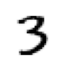

In [22]:
show_image(three_tensors[1]);

- For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 
- To do this we first combine all the images in this list into a single three-dimensional tensor.
- The most common way to describe such a tensor is to call it a *rank-3 tensor*.
- We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [23]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

In [24]:
len(stacked_threes.shape)
# rank is the number of axes in a tensor
# shape is the size of each axis of a tensor

3

We can also get a tensor's rank directly with `ndim`:

In [ ]:
stacked_threes.ndim

3

- Finally, we can compute what the ideal 3 looks like. 
- We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

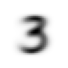

In [25]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

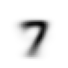

In [26]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

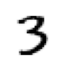

In [27]:
a_3 = stacked_threes[1]
show_image(a_3);

There are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or **L1 norm**
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or **L2 norm**.


Let's try both of these now:

In [28]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [29]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

## NumPy Arrays and PyTorch Tensors

- [NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. 
- It provides very similar functionality and a very similar API to that provided by PyTorch; **however, it does not support using the GPU or calculating gradients, which are both critical for deep learning.** Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

- A NumPy array is a multidimensional table of data, with all items of the same type. 
- Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.



- A **PyTorch tensor** is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities.
- It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. 
**For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.**

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. 


- **One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on).**
- **In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.


To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

In [30]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [31]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [32]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

In [33]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

or a column, by using `:` to indicate *all of the first axis* (we sometimes refer to the dimensions of tensors/arrays as *axes*):

In [34]:
tns[:, 1]

tensor([2, 5])

You can combine these with Python slice syntax (`[start:end]` with `end` being excluded) to select part of a row or column:

In [35]:
tns[1:, ]

tensor([[4, 5, 6]])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [ ]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

## Computing Metrics Using Broadcasting

In [36]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [37]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2)) # fixing the image count axis


In [38]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- **PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory**
- It does the whole calculation in C (**or, if you're using a GPU, in CUDA, the equivalent of C on the GPU**), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*

- Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes.
- In Python, `-1` refers to the last element, and `-2` refers to the second-to-last.
- So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. 
- In other words, for every image, we averaged the intensity of all the pixels in that image.


## Baseline - 95.11% accuracy

In [40]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x,mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [44]:
is_3(valid_3_tens)


accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1-is_3(valid_7_tens).float().mean())

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Stochastic Gradient Descent (SGD)

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?

- Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. 
- We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

- As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

- **Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category.**
- For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w) = (x*w).sum()
```

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- **Initialize::** 
    - We initialize the parameters to random values. 
    - This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
    
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (**the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention**).


- **Step::** A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- **Stop::** Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. 
- **This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.**

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

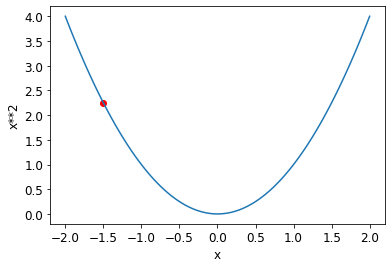

In [46]:

def f(x):
    return x**2

plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

- **One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight.**
- **But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.**

- **We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.**

First, let's pick a tensor value which we want gradients at:

In [48]:
xt = tensor(3.).requires_grad_()
yt = f(xt)
print(yt)
yt.backward() # backward here refers to backpropogation (better name would be calculate_graf)
xt.grad

tensor(9., grad_fn=<PowBackward0>)


tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!

Now we'll repeat the preceding steps, but with a vector argument for our function:

In [49]:
xt = tensor([3., 4. , 5.]).requires_grad_()
def f(x):
    return (x**2).sum()

yt = f(xt)
yt.backward()
xt.grad

tensor([ 6.,  8., 10.])

- **The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters.**
- **But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.**

##  Learning Rate

- Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. 
- Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). 
- The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the *learning rate finder*).
- Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*.


## An End-to-End SGD Example

In [66]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

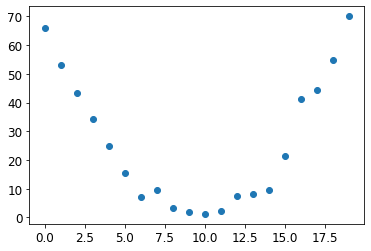

In [67]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

- We've added a bit of random noise, since measuring things manually isn't precise. 
- This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. 
- We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

In [68]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c


- In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

- **We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:**

In [69]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [70]:
# initialize the parameters to random values
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

### Step 2: Calculate the predictions

Next, we calculate the predictions:

torch.Size([20])

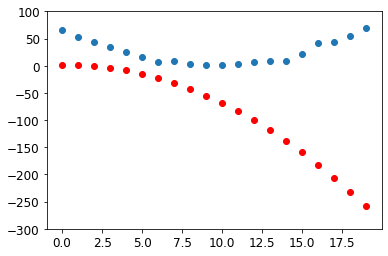

In [71]:
preds = f(time, params)
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)

preds.shape

### Step 3: Calculate the loss

We calculate the loss as follows:

In [72]:
loss = mse(preds, speed)
print(loss)

tensor(20858.0801, grad_fn=<MeanBackward0>)


Our goal is now to improve this. To do that, we'll need to know the gradients.

### Step 4: Calculate the gradients

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [73]:
loss.backward()
params.grad

tensor([-47743.6484,  -3047.7844,   -224.2141])

### Step 5: Step the weights. 

Now we need to update the parameters based on the gradients we just calculated:

In [74]:
lr = 1e-5
params.data -= lr* params.grad.data
params.grad = None

In [75]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    
    return preds


### Step 6: Repeat the process 

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [76]:
for i in range(10): apply_step(params)

4435.89990234375
1328.318359375
740.2652587890625
628.9837646484375
607.9219970703125
603.9327392578125
603.1740112304688
603.0264892578125
602.9948120117188
602.9851684570312


### Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

# The MNIST Loss Function

- We already have our dependent variables `x`—these are the images themselves. 
- We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). 
- **We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":**

In [79]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]* len(threes) + [0]*len(sevens)).unsqueeze(1) 
# 1 for image 3 and 0 for image 1
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

- **A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed.**
- Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [83]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [84]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [85]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))


The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

In [86]:
bias = init_params(1)

**In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.**

- jargon: Parameters: The _weights_ and _biases_ of a model. The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

We can now calculate a prediction for one image:

In [87]:
(train_x[0]*weights.T).sum() + bias

tensor([3.7602], grad_fn=<AddBackward0>)

In [88]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
print(preds.shape)
preds

torch.Size([12396, 1])


tensor([[ 3.7602],
        [10.0223],
        [15.1395],
        ...,
        [ 4.7646],
        [ 1.8502],
        [ 3.3399]], grad_fn=<AddBackward0>)

In [95]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

## without sigmoid

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [96]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

Let's try it on our `prds` and `trgts`:

In [98]:
print(torch.where(trgts==1, 1-prds, prds))
mnist_loss(prds, trgts)


tensor([0.1000, 0.4000, 0.8000])


tensor(0.4333)

**One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.*8

## Sigmoid

The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

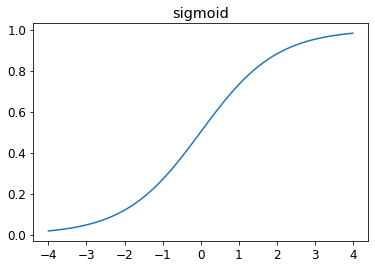

In [101]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))
plot_function(torch.sigmoid, title='sigmoid', min=-4, max=4)

In [109]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()


As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

## SGD and Mini-Batches

- Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

- In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. 
- **Calculating it for the whole dataset would take a very long time.**
- **Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient.**


- **So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*.**
- The number of data items in the mini-batch is called the *batch size*. 
- Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.

- **Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU.**
- **These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on.**
- **Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!**

- A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

In [110]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([10,  4,  1,  2,  6]),
 tensor([ 8,  7,  9, 13, 11]),
 tensor([ 0, 12,  5, 14,  3])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

We are now ready to write our first training loop for a model using SGD!

## Putting It All Together

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's re-initialize our parameters:

In [111]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

In [112]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape


(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [113]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [114]:
batch = train_x[:4]
preds = linear1(batch)
loss = mnist_loss(preds, train_y[:4])
print(loss)
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

tensor(0.9099, grad_fn=<MeanBackward0>)


(torch.Size([784, 1]), tensor(-0.0100), tensor([-0.0698]))

Let's put that all in a function:

In [115]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()


and test it:

In [116]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0200), tensor([-0.1396]))

But look what happens if we call it twice:

In [117]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0300), tensor([-0.2095]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [118]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [126]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()


We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

That gives us this function to calculate our validation accuracy:

In [127]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [128]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

and then put the batches together:

In [129]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [130]:
validate_epoch(linear1)

0.5177

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [131]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6528

Then do a few more:

In [132]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8383 0.9101 0.9394 0.9501 0.9545 0.9604 0.9643 0.9667 0.9677 0.9697 0.9706 0.9706 0.9711 0.9726 0.9731 0.9726 0.9726 0.9736 0.9736 0.9741 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

## Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [143]:
linear_model = nn.Linear(28*28,1)

linear_model = nn.Linear(28*28,1)
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

We can use this information to create an optimizer:

In [144]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data  -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

We can create our optimizer by passing in the model's parameters:

In [145]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [146]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()


Our validation function doesn't need to change at all:

In [147]:
validate_epoch(linear_model)

0.4816

Let's put our little training loop in a function, to make things simpler:

In [148]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [149]:
train_model(linear_model, 20)

0.4932 0.8906 0.8179 0.9072 0.9297 0.9453 0.9541 0.9619 0.9653 0.9668 0.9697 0.9712 0.9726 0.9746 0.9756 0.9761 0.9775 0.9775 0.9785 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [150]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7485 0.8554 0.9184 0.9355 0.9487 0.957 0.9624 0.9663 0.9673 0.9692 0.9712 0.9736 0.9751 0.9761 0.977 0.9775 0.978 0.978 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [151]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func = mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636943,0.503398,0.495584,00:00
1,0.500889,0.187078,0.842493,00:00
2,0.184395,0.177970,0.841021,00:00
3,0.081131,0.105771,0.911187,00:00
4,0.043156,0.077696,0.932287,00:00
5,0.028349,0.062406,0.947498,00:00
6,0.022264,0.052819,0.956330,00:00
7,0.019556,0.046421,0.962709,00:00
8,0.018178,0.041923,0.965653,00:00
9,0.017347,0.038611,0.966634,00:00


To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [152]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [153]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

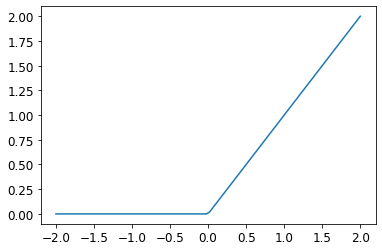

In [154]:
plot_function(F.relu)

> J: **There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_.** The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn to be referring to a very simple concept.

- The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. 
- But there's no point just putting one linear layout directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! 

- **That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.**

- **But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.**

> S: **Mathematically, we say the composition of two linear functions is another linear function.** So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [160]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,15),
    nn.ReLU(),
    nn.Linear(15, 1)
)

- `nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

- `nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

- Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! 
- **As this is a deeper model, we'll use a lower learning rate and a few more epochs.**

In [162]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.05)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.012298,0.018730,0.982336,00:00
1,0.011817,0.018633,0.982336,00:00
2,0.011610,0.018581,0.982336,00:00
3,0.011488,0.018533,0.982336,00:00
4,0.011395,0.018484,0.982336,00:00
5,0.011313,0.018436,0.982336,00:00
6,0.011237,0.018388,0.982336,00:00
7,0.011163,0.018341,0.982826,00:00
8,0.011092,0.018294,0.983317,00:00
9,0.011023,0.018248,0.983317,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

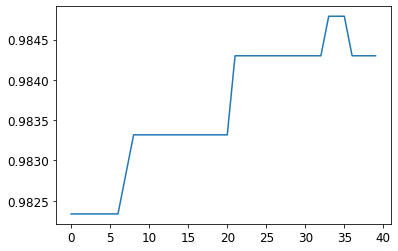

In [163]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [164]:
learn.recorder.values[-1][2]

0.9842983484268188

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

- This is why deep learning can do things which seem rather magical such fantastic things.
- Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

### Going Deeper

- There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. 
- As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. 
Here what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

In [165]:
print(path)
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/Users/paritoshgupta/.fastai/data/mnist_sample


epoch,train_loss,valid_loss,accuracy,time
0,0.141258,0.021856,0.993621,02:15


- Nearly 100% accuracy! That's a big difference compared to our simple neural net.
- But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. 
- You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

# Jargon Recap

- Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.

- A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

    - **Activations::** Numbers that are calculated (both by linear and nonlinear layers)
    - **Parameters::** Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

- We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. 
- Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. **We generally alternate between these two kinds of layers in a neural network.** Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.

- **ReLU:** Function that returns 0 for negative numbers and doesn't change positive numbers.
- **Mini-batch:**  A smll group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
- **Forward pass**: Applying the model to some input and computing the predictions.
- **Loss:**  A value that represents how well (or badly) our model is doing.
- **Gradient** The derivative of the loss with respect to some parameter of the model.
- **Backard pass:**  Computing the gradients of the loss with respect to all model parameters.
- **Gradient descent:** Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
- **Learning rate**:   The size of the step we take when applying SGD to update the parameters of the model.


## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?